## Imports

In [1]:
import pandas as pd
import numpy as np
import copy
import torch
import re
import collections
import string
from transformers import AutoModel, AutoConfig, AutoTokenizer, AutoModelForQuestionAnswering
from transformers import pipeline
from transformers import DataCollatorWithPadding, DefaultDataCollator
from torch.utils.data import DataLoader
from datasets import Dataset
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
import torch.nn as nn
import torch.nn.functional as F
import gc
from tqdm import tqdm
import os
# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['TOKENIZERS_PARALLELISM'] = "False"

In [2]:
class Config:
    max_length = 384
    doc_stride = 128
    train_batch_size = 64
    valid_batch_size = 16
    n_accumulate = 1
    n_folds = 5
    num_epochs = 1
    collate_fn = DefaultDataCollator()
    lr = 9e-5
    weight_decay = 0.001
    warmup_prop=0.15
    pad_on_right = None
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    student_model_name = "deepset/tinyroberta-squad2"
    teacher_model_name = "nlpconnect/roberta-base-squad2-nq"
    s_tokenizer = None
    seed = 42
    wandb_run_name = "disitilbert-NQ"

    # Distillation params
    temp = 2
    alpha = 0.5
    
config = Config()
config.s_tokenizer = AutoTokenizer.from_pretrained(config.student_model_name)
config.pad_on_right = config.s_tokenizer.padding_side == "right" 

Downloading:   0%|          | 0.00/383 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/780k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [3]:
def seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
seed(config.seed)

## Preprocessing

In [4]:
df = pd.read_csv("/kaggle/input/inter-iit-devrev/train_5folds.csv")
df['Answer_possible'] = df['Answer_possible'].astype(np.int16)
df['Answer_text'] = df.Answer_text.apply(eval)
# df['Answer_text'] = df.Answer_text.apply(lambda x:[x] if x=='' else x)
df['Answer_start'] = df.Answer_start.apply(eval)
df['Answer_start'] = df.Answer_start.apply(lambda x: [int(x[0])] if len(x) > 0 else [0])
df['answer_end'] = (df['Answer_start'].apply(lambda x:x[0]) + df['Answer_text'].apply(lambda x:len(x[0]) if len(x)>0 else 0)).apply(lambda x:[x])

df.rename(columns={df.columns[0]:'id', 'Paragraph':'context',
                   'Question':'question',
                   'Answer_text':'answer',
                   'Answer_start':'answer_start',
                   'Answer_possible':'answer_possible'}, inplace=True)
df['context'] = df['context'].apply(lambda t : t.strip())

In [5]:
df.head()

,id,Theme,context,question,answer_possible,answer,answer_start,fold,answer_end
0,2,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce leave Destiny's Child and bec...,1,[2003],[526],1,[530]
1,6,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What album made her a worldwide known artist?,1,[Dangerously in Love],[505],1,[524]
2,7,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,Who managed the Destiny's Child group?,1,[Mathew Knowles],[360],1,[374]
3,8,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyoncé rise to fame?,1,[late 1990s],[276],1,[286]
4,9,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What role did Beyoncé have in Destiny's Child?,1,[lead singer],[290],1,[301]


In [6]:
def process_text(inp, config=config):
    tokenized_inp = config.s_tokenizer(inp['question'],
                             inp['context'],
                              add_special_tokens=True,
                             truncation='only_second',
                             max_length=config.max_length,
                             stride=config.doc_stride,
                             return_offsets_mapping=True,
                             return_overflowing_tokens=True,
                             padding='max_length',
                             return_token_type_ids=True)
    
    sample_mapping = tokenized_inp.pop("overflow_to_sample_mapping")

    offset_mapping = tokenized_inp.pop("offset_mapping")
    
    start_positions = []
    end_positions = []
    
    for i, offsets in enumerate(offset_mapping):
        # We will label impossible answers with the index of the CLS token.
        input_ids = tokenized_inp["input_ids"][i]
        cls_index = input_ids.index(config.s_tokenizer.cls_token_id)

        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_inp.sequence_ids(i)

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]

        # If no answers are given, set the cls_index as answer.
        if inp['answer_possible'][sample_index] == 0:
            start_positions.append(cls_index)
            end_positions.append(cls_index)
        else:
            # Start/end character index of the answer in the text.
            start_char = inp["answer_start"][sample_index][0]
            end_char = inp['answer_end'][sample_index][0]

            # Start token index of the current span in the text.
            token_start_index = 0
            while sequence_ids[token_start_index] != (1 if config.pad_on_right else 0):
                token_start_index += 1

            # End token index of the current span in the text.
            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != (1 if config.pad_on_right else 0):
                token_end_index -= 1

            # Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
            if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
                start_positions.append(cls_index)
                end_positions.append(cls_index)
            else:
                # Otherwise move the token_start_index and token_end_index to the two ends of the answer.
                # Note: we could go after the last offset if the answer is the last word (edge case).
                while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                    token_start_index += 1
                start_positions.append(token_start_index - 1)
                while offsets[token_end_index][1] >= end_char:
                    token_end_index -= 1
                end_positions.append(token_end_index + 1)
    
    tokenized_inp["start_positions"] = start_positions
    tokenized_inp["end_positions"] = end_positions

    return tokenized_inp


## Loss

In [ ]:
def criterion(pred1, pred2, out1, out2, gt=False):
    if gt:
        l1 = nn.CrossEntropyLoss()(input=pred1, target=out1.to(torch.long))
        l2 = nn.CrossEntropyLoss()(input=pred2, target=out2.to(torch.long))
    else:
        l1 = nn.CrossEntropyLoss()(input=pred1, target=F.softmax(out1, dim=-1))
        l2 = nn.CrossEntropyLoss()(input=pred2, target=F.softmax(out2, dim=-1))

    loss = l1+l2

    return loss

In [ ]:
def train_epoch(student_model, teacher_model, data_loader, optimizer, scheduler, epoch, scaler, device):#, accelerator):

    student_model.train()
    teacher_model.eval()

    dataset_size = 0
    running_loss = 0.0
    
    bar = tqdm(enumerate(data_loader), total=len(data_loader))
    
    for step, data in bar:
        ids = data['input_ids'].to(device)
        mask = data['attention_mask'].to(device)
        token_type_ids = data['token_type_ids'].to(device)
        
        gt1 = data['start_positions'].to(device)
        gt2 = data['end_positions'].to(device)
        batch_size = ids.size(0)

        with torch.autocast(device_type='cuda'):
            with torch.no_grad():
                out = teacher_model(ids, attention_mask=mask)
                out1, out2 = out.start_logits, out.end_logits
          
            pred = student_model(ids, attention_mask=mask)
            pred1, pred2 = pred.start_logits, pred.end_logits
            loss = criterion(pred1, pred2, out1, out2)
            loss = loss / config.n_accumulate

        scaler.scale(loss).backward()
             
        if (step + 1) % config.n_accumulate == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
                
                
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        del pred, pred1, pred2, gt1, gt2, out, out1, out2
        _ = gc.collect() 
        
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])
    gc.collect()
    
    return epoch_loss
        

In [ ]:
@torch.no_grad()
def valid_epoch(student_model, teacher_model, data_loader, epoch, device):
    
    student_model.eval()
    teacher_model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    running_gt_loss = 0.0
    
    bar = tqdm(enumerate(data_loader), total=len(data_loader))
    
    for step, data in bar:        
        ids = data['input_ids'].to(device)
        mask = data['attention_mask'].to(device)
        token_type_ids = data['token_type_ids'].to(device)
        
        gt1 = data['start_positions'].to(device)
        gt2 = data['end_positions'].to(device)
                
        batch_size = ids.size(0)
                    
        with torch.autocast(device_type='cuda'):
            out = teacher_model(ids, attention_mask=mask)
            out1, out2 = out.start_logits, out.end_logits
            
            pred = student_model(ids, attention_mask=mask)
            pred1, pred2 = pred.start_logits, pred.end_logits
            
            loss = criterion(pred1, pred2, out1, out2)
            loss_gt = criterion(pred1, pred2, gt1, gt2, gt=True)
        
        
        del pred, pred1, pred2, gt1, gt2, out, out1, out2
        _ = gc.collect()    

        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        running_gt_loss += (loss_gt.item() * batch_size)
        
        epoch_loss = running_loss / dataset_size
        epoch_loss_gt = running_gt_loss / dataset_size

        
        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss, Ground_Truth_Loss=epoch_loss_gt)   
    
    gc.collect()
    
    return epoch_loss


In [ ]:
# Fold 1
fold = 1

# df = df.sample(200)

df_train = df[df.fold != fold].reset_index(drop=True)
df_valid = df[df.fold == fold].reset_index(drop=True)

train_dataset = Dataset.from_pandas(df_train).map(process_text, batched=True, remove_columns=list(df.columns))
valid_dataset = Dataset.from_pandas(df_valid).map(process_text, batched=True, remove_columns=list(df.columns))

In [ ]:
print(f"Tokenized data: {len(train_dataset)+len(valid_dataset)}, Original data: {len(df)}")
print(f"Overflow Samples: {len(train_dataset)+len(valid_dataset) - len(df)} (max_length = {config.max_length})")

## Training

In [ ]:
def train(train_dataset, valid_dataset, fold, config=config, model_path=None):
    
    train_loader = DataLoader(train_dataset, batch_size=config.train_batch_size, collate_fn=config.collate_fn, 
                              num_workers=2, shuffle=True, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=config.valid_batch_size, collate_fn=config.collate_fn,
                              num_workers=2, shuffle=False, pin_memory=True)

    num_train_steps = int(len(train_dataset) / config.train_batch_size * config.num_epochs)
    
    scaler = torch.cuda.amp.GradScaler()

    student_model = AutoModelForQuestionAnswering.from_pretrained(config.student_model_name)
    
    if model_path != None:
        checkpoint = torch.load(model_path)
        student_model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        
    student_model = student_model.to(config.device)
    teacher_model = AutoModelForQuestionAnswering.from_pretrained(config.teacher_model_name).to(config.device)

    # To automatically log gradients
#     wandb.watch(student_model, log_freq=100)
    
    optimizer = AdamW(optimizer_params(student_model), lr=config.lr)
    scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=config.warmup_prop*num_train_steps, 
                                                num_training_steps=num_train_steps)
    
    best_epoch_loss = np.inf
    
    history = {'Train_loss':[], "Valid_loss":[]}
    
    for epoch in range(1, config.num_epochs+1):
        
        train_epoch_loss = train_epoch(student_model, teacher_model, train_loader, optimizer, scheduler, epoch, scaler, config.device)
        
        valid_epoch_loss = valid_epoch(student_model, teacher_model, valid_loader, epoch, config.device)
        
        history['Train_loss'].append(train_epoch_loss)
        history['Valid_loss'].append(valid_epoch_loss)
        
#         wandb.log({"Train Loss": train_epoch_loss})
#         wandb.log({"Valid Loss": valid_epoch_loss})
        
        
        if valid_epoch_loss <= best_epoch_loss:
            print(f"Validation Loss Improved ({best_epoch_loss} ---> {valid_epoch_loss})")
            best_epoch_loss = valid_epoch_loss
            PATH = f"Epoch-{epoch}-Fold-{fold}.pth"
            torch.save({
                "model": student_model.state_dict()
            }, PATH)
            print(f"Model Saved")
#             run.summary["Best Loss"] = best_epoch_loss
    
    print("Best_epoch_loss: ",best_epoch_loss)
    
    del student_model, teacher_model
    _ = gc.collect()
    
    return history   
        

In [ ]:
def optimizer_params(model, config=config):
    param_optimizer = list(model.named_parameters())
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    optimizer_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': config.weight_decay},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
    ]
    return optimizer_parameters

In [ ]:
print(f"====== Fold: {fold} ======")
# run = wandb.init(project="Distillation-QA", entity="amish_grwl", name=config.wandb_run_name)
history = train(train_dataset, valid_dataset, fold)
# run.finish()
print()

## Inference

In [160]:
PATH = "/kaggle/input/epoch1fold1train/Epoch-1-Fold-1.pth"

In [161]:
student_model = AutoModelForQuestionAnswering.from_pretrained(config.student_model_name)

In [162]:
student_model.load_state_dict(torch.load(PATH), strict=False) 

_IncompatibleKeys(missing_keys=['roberta.embeddings.position_ids', 'roberta.embeddings.word_embeddings.weight', 'roberta.embeddings.position_embeddings.weight', 'roberta.embeddings.token_type_embeddings.weight', 'roberta.embeddings.LayerNorm.weight', 'roberta.embeddings.LayerNorm.bias', 'roberta.encoder.layer.0.attention.self.query.weight', 'roberta.encoder.layer.0.attention.self.query.bias', 'roberta.encoder.layer.0.attention.self.key.weight', 'roberta.encoder.layer.0.attention.self.key.bias', 'roberta.encoder.layer.0.attention.self.value.weight', 'roberta.encoder.layer.0.attention.self.value.bias', 'roberta.encoder.layer.0.attention.output.dense.weight', 'roberta.encoder.layer.0.attention.output.dense.bias', 'roberta.encoder.layer.0.attention.output.LayerNorm.weight', 'roberta.encoder.layer.0.attention.output.LayerNorm.bias', 'roberta.encoder.layer.0.intermediate.dense.weight', 'roberta.encoder.layer.0.intermediate.dense.bias', 'roberta.encoder.layer.0.output.dense.weight', 'roberta.

In [163]:
# student_model.load_state_dict(torch.load(PATH))

In [164]:
Config = {
    'max_length' : 512,
    'model_name' : 'deepset/tinyroberta-squad2',
    'stride' : 128,
    'batch_size' : 16,
    'device' : torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
}
Config["tokenizer"] = AutoTokenizer.from_pretrained(Config['model_name'])

In [165]:
df = pd.read_csv('/kaggle/input/inter-iit-devrev/squad_validation_data.csv')
df.reset_index(level=0, inplace=True)
df.rename(columns = {'index':'id'}, inplace = True)

In [166]:
for i in range(0, len(df)):
    if df['text'][i] == '[]':
        df['answer_start'][i] = 0
    else :
        df['answer_start'][i] = df['answer_start'][i]

In [167]:
df.head(10)

,id,question,context,answer_start,text
0,0,In what country is Normandy located?,The Normans (Norman: Nourmands; French: Norman...,159,France
1,1,When were the Normans in Normandy?,The Normans (Norman: Nourmands; French: Norman...,94,10th and 11th centuries
2,2,From which countries did the Norse originate?,The Normans (Norman: Nourmands; French: Norman...,256,"Denmark, Iceland and Norway"
3,3,Who was the Norse leader?,The Normans (Norman: Nourmands; French: Norman...,308,Rollo
4,4,What century did the Normans first gain their ...,The Normans (Norman: Nourmands; French: Norman...,671,10th century
5,5,Who gave their name to Normandy in the 1000's ...,The Normans (Norman: Nourmands; French: Norman...,0,[]
6,6,What is France a region of?,The Normans (Norman: Nourmands; French: Norman...,0,[]
7,7,Who did King Charles III swear fealty to?,The Normans (Norman: Nourmands; French: Norman...,0,[]
8,8,When did the Frankish identity emerge?,The Normans (Norman: Nourmands; French: Norman...,0,[]
9,9,Who was the duke in the battle of Hastings?,"The Norman dynasty had a major political, cult...",1022,William the Conqueror


In [168]:
pad_on_right = Config['tokenizer'].padding_side == "right"

In [169]:
class ValidDataset(Dataset):
    
    def __init__(self, df, tokenizer, max_length, stride):
        
        self.df = df
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.stride = stride
        self.questions = df['question'].values
        self.contexts = df['context'].values
        
    def __len__(self):
        
        return len(self.df)
    
    def __getitem__(self, idx):
        
        question = self.questions[idx]
        context = self.contexts[idx]
        tokenized_inp = self.tokenizer(
        question,
        context,
        max_length=self.max_length,
        truncation='only_second',
        stride=self.stride,
        padding="max_length",
        return_token_type_ids=True
    )
        return tokenized_inp

In [170]:
collate_fn = DataCollatorWithPadding(tokenizer=Config['tokenizer'])

In [171]:
valid_dataset = ValidDataset(df, Config['tokenizer'], Config['max_length'], Config['stride'])

In [172]:
valid_loader =  DataLoader(valid_dataset, batch_size= Config['batch_size'], collate_fn=collate_fn,
                              num_workers=2, shuffle=False, pin_memory=True, drop_last = True)

In [173]:
class QA_BERT(nn.Module):
    def __init__(self):
        super(QA_BERT, self).__init__()
        self.student_model = AutoModelForQuestionAnswering.from_pretrained(config.student_model_name)
#         self.model = AutoModelForQuestionAnswering.from_pretrained(Config['model_name'])
#         self.student_model = student_model.load_state_dict(torch.load(PATH))
#         self.student_model = torch.load(PATH)
        self.student_model.load_state_dict(torch.load(PATH), strict=False)
        
    
    def forward(self, ids, mask, token_type_ids):
        out = self.student_model(ids, attention_mask=mask, token_type_ids=token_type_ids)
        return out.start_logits, out.end_logits

In [174]:
model = QA_BERT()

## Metrics

In [175]:
def normalize_answer(s):
    """Lower text and remove punctuation, articles and extra whitespace."""
    return white_space_fix(remove_articles(remove_punc(lower(s))))
def remove_articles(text):
    regex = re.compile(r'\b(a|an|the)\b', re.UNICODE)
    return re.sub(regex, ' ', text)
def white_space_fix(text):
    return ' '.join(text.split())
def remove_punc(text):
    exclude = set(string.punctuation)
    return ''.join(ch for ch in text if ch not in exclude)
def lower(text):
    return text.lower()

In [176]:
def get_tokens(s):
    if not s: 
        return []
    return normalize_answer(s).split()

In [177]:
def compute_exact(a_gold, a_pred):
    return int(normalize_answer(a_gold) == normalize_answer(a_pred))

In [178]:
def compute_f1(a_gold, a_pred):
    gold_toks = get_tokens(a_gold)
    pred_toks = get_tokens(a_pred)
    common = collections.Counter(gold_toks) & collections.Counter(pred_toks)
    num_same = sum(common.values())
    if len(gold_toks) == 0 or len(pred_toks) == 0:
    # If either is no-answer, then F1 is 1 if they agree, 0 otherwise
        return int(gold_toks == pred_toks)
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(pred_toks)
    recall = 1.0 * num_same / len(gold_toks)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1

In [179]:
def prediction(data, model, tokenizer):
    text = []
    start_idx = []
    scores = []
    f1_score = []
    exact_score = []
    model = pipeline('question-answering', model=student_model, tokenizer=tokenizer, handle_impossible_answer=False)
    for i in tqdm(range(df.shape[0])):
        question = df['question'][i]
        context = df['context'][i]
        target = df['text'][i]
        input = {
          'question': question,
          'context': context
    }
        res = model(input)
        if(res['score'] > 0.0):
            txt = res['answer']
            st_idx = res['start']
            scr = res['score']
        else:
            txt = '[]'
            st_idx = '0'
        text.append(txt)
        start_idx.append(st_idx)
        scores.append(scr)
        f1_acc = compute_f1(target, txt)
        em_acc = compute_exact(target, txt)
        f1_score.append(f1_acc)
        exact_score.append(em_acc)
        
    return text, start_idx, f1_score, exact_score, scores 

In [180]:
text, start_idx, f1_score, exact_score, scores = prediction(df, student_model, config.student_model_name)

100%|██████████| 11873/11873 [35:23<00:00,  5.59it/s] 


In [181]:
df.head(10)

,id,question,context,answer_start,text
0,0,In what country is Normandy located?,The Normans (Norman: Nourmands; French: Norman...,159,France
1,1,When were the Normans in Normandy?,The Normans (Norman: Nourmands; French: Norman...,94,10th and 11th centuries
2,2,From which countries did the Norse originate?,The Normans (Norman: Nourmands; French: Norman...,256,"Denmark, Iceland and Norway"
3,3,Who was the Norse leader?,The Normans (Norman: Nourmands; French: Norman...,308,Rollo
4,4,What century did the Normans first gain their ...,The Normans (Norman: Nourmands; French: Norman...,671,10th century
5,5,Who gave their name to Normandy in the 1000's ...,The Normans (Norman: Nourmands; French: Norman...,0,[]
6,6,What is France a region of?,The Normans (Norman: Nourmands; French: Norman...,0,[]
7,7,Who did King Charles III swear fealty to?,The Normans (Norman: Nourmands; French: Norman...,0,[]
8,8,When did the Frankish identity emerge?,The Normans (Norman: Nourmands; French: Norman...,0,[]
9,9,Who was the duke in the battle of Hastings?,"The Norman dynasty had a major political, cult...",1022,William the Conqueror


In [182]:
df.insert(5, 'answer_possible', 0)

In [183]:
for i in range(0, len(df)):
    if df['text'][i] == '[]':
        df['answer_possible'][i] = 0
    else :
        df['answer_possible'][i] = 1

In [184]:
df.head()

,id,question,context,answer_start,text,answer_possible
0,0,In what country is Normandy located?,The Normans (Norman: Nourmands; French: Norman...,159,France,1
1,1,When were the Normans in Normandy?,The Normans (Norman: Nourmands; French: Norman...,94,10th and 11th centuries,1
2,2,From which countries did the Norse originate?,The Normans (Norman: Nourmands; French: Norman...,256,"Denmark, Iceland and Norway",1
3,3,Who was the Norse leader?,The Normans (Norman: Nourmands; French: Norman...,308,Rollo,1
4,4,What century did the Normans first gain their ...,The Normans (Norman: Nourmands; French: Norman...,671,10th century,1


In [185]:
df.insert(6, 'scores', scores)

In [186]:
df.insert(7, 'answer', text)

In [187]:
df.insert(8, 'answer_present', 0)

In [188]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

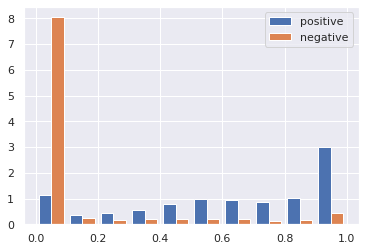

In [189]:
x1 = list(df[df['answer_possible'] == 1]['scores'])
x2 = list(df[df['answer_possible'] == 0]['scores'])
names=['positive', 'negative']
plt.hist([x1, x2], label=names, density=True)
plt.legend()

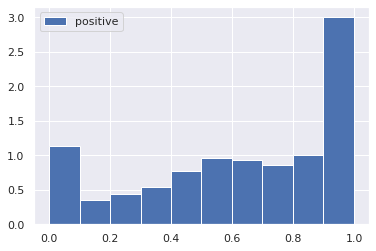

In [190]:
x1 = list(df[df['answer_possible'] == 1]['scores'])
names=['positive']
plt.hist([x1], label=names, density=True)
plt.legend()

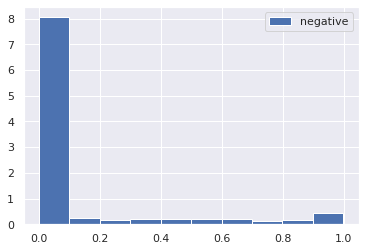

In [191]:
x2 = list(df[df['answer_possible'] == 0]['scores'])
names=['negative']
plt.hist([x2], label=names, density=True)
plt.legend()

In [192]:
print(len(x1))
print(len(x2))
print(len(df))

5928
5945
11873


In [193]:
print(len(scores))
print(len(df[df['answer_possible'] == 1]))

11873
5928


(array([5451.,  355.,  365.,  445.,  571.,  701.,  666.,  595.,  692.,
        2032.]),
 array([1.73181879e-12, 9.98877645e-02, 1.99775529e-01, 2.99663293e-01,
        3.99551058e-01, 4.99438822e-01, 5.99326587e-01, 6.99214351e-01,
        7.99102116e-01, 8.98989880e-01, 9.98877645e-01]),
 <BarContainer object of 10 artists>)

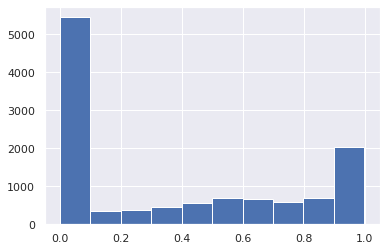

In [194]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.hist(scores)
# scores

In [195]:
print(len(df['answer'][5]))

11


In [196]:
def range_with_floats(start, stop, step):
    while stop > start:
        yield start
        start += step

In [197]:
df2 = pd.DataFrame({'FN':0, 'FP':0, 'ID':range_with_floats(0.0,0.82, 0.1)})

In [201]:
for j in range_with_floats(0.0, 0.82, 0.1):
    for i in range(len(df)):
        if df['scores'][i] < j:
            df['answer'][i] = ''
        if len(df['answer'][i]) == 0:
            df['answer_present'][i] = 0
        else :
            df['answer_present'][i] = 1

        if (df["answer_possible"][i] == 1 and df["answer_present"][i] == 1):
            df['type'][i] = 'tp'  # true positive
        elif (df["answer_possible"][i] == 0 and df["answer_present"][i] == 0):
            df['type'][i] = 'tn'  # true negative
        elif (df["answer_possible"][i] == 1 and df["answer_present"][i] == 0):
            df['type'][i] = 'fp'  # false postive
        elif (df["answer_possible"][i] == 0 and df["answer_present"][i] == 1):
            df['type'][i] = 'fn'   # false negative
    print(f"fn : {(len(df[df['type']=='fn']))}, with threshold: {round(j, 1)}")
    (df2[df2['ID'] == j]['FN']) = len(df[df['type']=='fn'])
#     print(df2['FN'])
    print(f"fp : {(len(df[df['type']=='fp']))}, with threshold: {round(j, 1)}")
    (df2[df2['ID'] == j]['FP']) = len(df[df['type']=='fp'])

fn : 5945, with threshold: 0.0
fp : 0, with threshold: 0.0
fn : 1168, with threshold: 0.1
fp : 674, with threshold: 0.1
fn : 1018, with threshold: 0.2
fp : 880, with threshold: 0.2
fn : 916, with threshold: 0.3
fp : 1142, with threshold: 0.3
fn : 790, with threshold: 0.4
fp : 1464, with threshold: 0.4
fn : 677, with threshold: 0.5
fp : 1924, with threshold: 0.5
fn : 548, with threshold: 0.6
fp : 2493, with threshold: 0.6
fn : 437, with threshold: 0.7
fp : 3052, with threshold: 0.7
fn : 351, with threshold: 0.8
fp : 3560, with threshold: 0.8


## Find Confusion matrix for a sample threshold

In [49]:
for i in range(0, len(df)):
    if len(df['answer'][i]) == 0:
        df['answer_present'][i] = 0
    else :
        df['answer_present'][i] = 1

In [50]:
df.head(10)

,id,question,context,answer_start,text,answer_possible,scores,answer,answer_present
0,0,In what country is Normandy located?,The Normans (Norman: Nourmands; French: Norman...,159,France,1,0.993690,France,1
1,1,When were the Normans in Normandy?,The Normans (Norman: Nourmands; French: Norman...,94,10th and 11th centuries,1,0.993690,[],1
2,2,From which countries did the Norse originate?,The Normans (Norman: Nourmands; French: Norman...,256,"Denmark, Iceland and Norway",1,0.821970,"Denmark, Iceland and Norway",1
3,3,Who was the Norse leader?,The Normans (Norman: Nourmands; French: Norman...,308,Rollo,1,0.947913,Rollo,1
4,4,What century did the Normans first gain their ...,The Normans (Norman: Nourmands; French: Norman...,671,10th century,1,0.696227,10th,1
5,5,Who gave their name to Normandy in the 1000's ...,The Normans (Norman: Nourmands; French: Norman...,0,[],0,0.995875,,0
6,6,What is France a region of?,The Normans (Norman: Nourmands; French: Norman...,0,[],0,0.995905,,0
7,7,Who did King Charles III swear fealty to?,The Normans (Norman: Nourmands; French: Norman...,0,[],0,0.998626,,0
8,8,When did the Frankish identity emerge?,The Normans (Norman: Nourmands; French: Norman...,0,[],0,0.999587,,0
9,9,Who was the duke in the battle of Hastings?,"The Norman dynasty had a major political, cult...",1022,William the Conqueror,1,0.993051,William the Conqueror,1


In [51]:
# get column 1 and column 2 data
col1 = df["answer_possible"].values
col2 = df["answer_present"].values

# initialize confusion matrix with zeros
confusion_matrix = torch.zeros(2, 2)

# populate confusion matrix
for i in range(len(col1)):
    if col1[i] == 1 and col2[i] == 1:
        confusion_matrix[0, 0] += 1  # true positive
    elif col1[i] == 0 and col2[i] == 0:
        confusion_matrix[1, 1] += 1  # true negative
    elif col1[i] == 1 and col2[i] == 0:
        confusion_matrix[0, 1] += 1  # false negative
    elif col1[i] == 0 and col2[i] == 1:
        confusion_matrix[1, 0] += 1  # false positive

print(confusion_matrix)

# find true positives
tp = confusion_matrix[0, 0].item()

# find true negatives
tn = confusion_matrix[1, 1].item()

# find false positives
fp = confusion_matrix[1, 0].item()

# find false negatives
fn = confusion_matrix[0, 1].item()

tensor([[5480.,  448.],
        [1376., 4569.]])


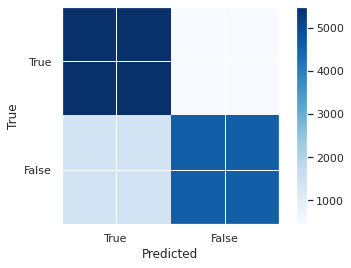

In [52]:
# create heatmap
plt.imshow(confusion_matrix, cmap='Blues')
plt.colorbar()

# set x and y ticks
plt.xticks(np.arange(2), ["True", "False"])
plt.yticks(np.arange(2), ["True", "False"])

# add labels
plt.xlabel('Predicted')
plt.ylabel('True')

plt.show()

<AxesSubplot:>

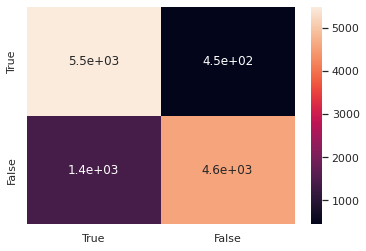

In [53]:
import seaborn as sns
sns.heatmap(confusion_matrix, xticklabels=["True", "False"], yticklabels=["True", "False"], annot=True)

In [54]:
col1 = df["text"].tolist()
print(len(col1))

11873


In [55]:
# get column 1 and column 2 data
col1 = df["text"].tolist()
col2 = df["answer"].tolist()
print(len(col2))
confusion_matrix = torch.zeros(len(set(col1)), len(set(col2)))

11873


In [56]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(col1, col2)
conf_mat = torch.tensor(conf_mat)

In [57]:
sns.heatmap(confusion_matrix, xticklabels=class_labels, yticklabels=class_labels, annot=True)

In [ ]:
# plotting the points 
plt.plot(scores, df['id'])
# naming the x axis
plt.xlabel('Scores')
# naming the y axis
plt.ylabel('y - axis')
# giving a title to my graph
plt.title('Confidence_Scores')
# function to show the plot
plt.show()

In [57]:
mf1_score = np.mean(f1_score[:])

In [58]:
print(mf1_score)

0.7167738757624528


In [59]:
mexact_score = np.mean(exact_score[:])

In [60]:
print(mexact_score)

0.6883685673376568


In [200]:
df.insert(9, 'type', 0)

In [94]:
df.head(10)

,id,question,context,answer_start,text,answer_possible,scores,answer,answer_present,type
0,0,In what country is Normandy located?,The Normans (Norman: Nourmands; French: Norman...,159,France,1,0.993690,France,1,2
1,1,When were the Normans in Normandy?,The Normans (Norman: Nourmands; French: Norman...,94,10th and 11th centuries,1,0.993690,[],1,2
2,2,From which countries did the Norse originate?,The Normans (Norman: Nourmands; French: Norman...,256,"Denmark, Iceland and Norway",1,0.821970,"Denmark, Iceland and Norway",1,2
3,3,Who was the Norse leader?,The Normans (Norman: Nourmands; French: Norman...,308,Rollo,1,0.947913,Rollo,1,2
4,4,What century did the Normans first gain their ...,The Normans (Norman: Nourmands; French: Norman...,671,10th century,1,0.696227,10th,1,2
5,5,Who gave their name to Normandy in the 1000's ...,The Normans (Norman: Nourmands; French: Norman...,0,[],0,0.995875,,0,2
6,6,What is France a region of?,The Normans (Norman: Nourmands; French: Norman...,0,[],0,0.995905,,0,2
7,7,Who did King Charles III swear fealty to?,The Normans (Norman: Nourmands; French: Norman...,0,[],0,0.998626,,0,2
8,8,When did the Frankish identity emerge?,The Normans (Norman: Nourmands; French: Norman...,0,[],0,0.999587,,0,2
9,9,Who was the duke in the battle of Hastings?,"The Norman dynasty had a major political, cult...",1022,William the Conqueror,1,0.993051,William the Conqueror,1,2


In [119]:
for i in range(0, len(df)):
#     term1 = df["answer_possible"][i]
#     term2 = df["answer_present"][i]
    if (df["answer_possible"][i] == 1 and df["answer_present"][i] == 1):
        df['type'][i] = 'tp'  # true positive
    elif (df["answer_possible"][i] == 0 and df["answer_present"][i] == 0):
        df['type'][i] = 'tn'  # true negative
    elif (df["answer_possible"][i] == 1 and df["answer_present"][i] == 0):
        df['type'][i] = 'fp'  # false negative
    elif (df["answer_possible"][i] == 0 and df["answer_present"][i] == 1):
        df['type'][i] = 'fn'   # false postive

In [120]:
print((df['type'][7]))

tn


In [121]:
print(len(df[df['type']=='fn']))

1376


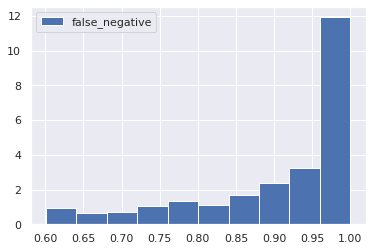

In [101]:
x3 = list(df[df['type'] == 'fn']['scores'])
names=['false_negative']
plt.hist([x3], label=names, density=True)
plt.legend()

In [95]:
# get column 1 and column 2 data
col1 = df["answer_possible"].values
col2 = df["answer_present"].values

# initialize confusion matrix with zeros
confusion_matrix = torch.zeros(2, 2)

# populate confusion matrix
for i in range(len(col1)):
    if col1[i] == 1 and col2[i] == 1:
        confusion_matrix[0, 0] += 1  # true positive
    elif col1[i] == 0 and col2[i] == 0:
        confusion_matrix[1, 1] += 1  # true negative
    elif col1[i] == 1 and col2[i] == 0:
        confusion_matrix[0, 1] += 1  # false negative
    elif col1[i] == 0 and col2[i] == 1:
        confusion_matrix[1, 0] += 1  # false positive

print(confusion_matrix)

# find true positives
tp = confusion_matrix[0, 0].item()

# find true negatives
tn = confusion_matrix[1, 1].item()

# find false positives
fp = confusion_matrix[1, 0].item()

# find false negatives
fn = confusion_matrix[0, 1].item()

tensor([[5480.,  448.],
        [1376., 4569.]])
